
# <span style="color:rgb(213,80,0)">Using the CLASSIX python package in MATLAB</span>
## MATLAB and Python versions

When working with Python, it is suggested that you use the most recent version of MATLAB possible since the MATLAB-Python interoperability is improving quickly. Please refer to [Versions of Python Compatible with MATLAB Products by Release - MATLAB & Simulink (mathworks.com)](https://uk.mathworks.com/support/requirements/python-compatibility.html) to find out which Python versions are supported by your current MATLAB version. The best place to download a Python installation is [Download Python | Python.org](https://www.python.org/downloads/). Note that Python installations that come with the Anaconda or other distributions might not be fully supported.


We begin by ensuring that our Python environment is set up. The following command makes use of the system Python. Ensure that this version of Python has the CLASSIX clustering package installed. If this isn't the case, simply run **<samp>pip install classixclustering</samp>** on your command line. You might then have to restart MATLAB for the CLASSIX package to be available.


In [1]:
pe = pyenv()

pe = 
  PythonEnvironment with properties:
          Version: "3.11"
       Executable: "C:\Program Files\Python311\python.exe"
          Library: "C:\Program Files\Python311\python311.dll"
             Home: "C:\Program Files\Python311"
           Status: Loaded
    ExecutionMode: InProcess
        ProcessID: "23976"
      ProcessName: "MATLAB"


It is also possible to use a venv Python environment. To do this, comment out the line above and uncomment the line below, changing the path to point to the Python executable in the version of Python you want to run.


In [2]:
% pe = pyenv(Version="C:\Program Files\Python311\python.exe")


Let's try a quick Python calculation to make sure the basics are all working OK.  All Python commands must be prefixed with **<samp>py.</samp>** So, to compute the Python command <samp>math.sqrt(42)</samp> we do:


In [3]:
py.math.sqrt(42)

ans = 6.4807

### Performing a basic clustering analysis on MATLAB data using CLASSIX

Let's start by generating and plotting some data using MATLAB.



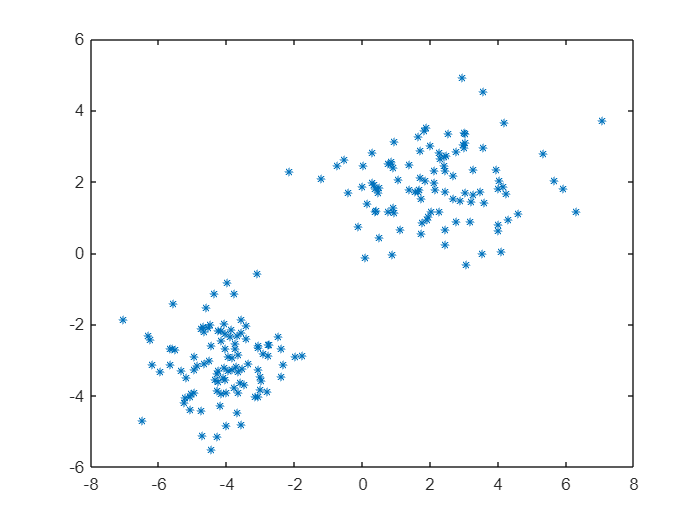

In [4]:
rng('default')        % For reproducibility
mu1 = [2 2];          % Mean of the 1st cluster
sigma1 = [2 0; 0 1];  % Covariance of the 1st cluster
mu2 = [-4 -3];        % Mean of the 2nd cluster
sigma2 = [1 0; 0 1];  % Covariance of the 2nd cluster
r1 = mvnrnd(mu1,sigma1,100);
r2 = mvnrnd(mu2,sigma2,100);
X = [r1; r2];
plot(X(:,1),X(:,2),"*",MarkerSize=5);


Calling CLASSIX is straightforward. We don't even need to convert the MATLAB array X to a Numpy array as it's all done automatically.


In [5]:
clx = py.classix.CLASSIX(radius=0.3, verbose=0);
clx = clx.fit(X);
clx.explain(plot=false);

A clustering of 200 data points with 2 features has been performed. 
The radius parameter was set to 0.30 and MinPts was set to 0. 
As the provided data has been scaled by a factor of 1/4.03,
data points within a radius of R=0.30*4.03=1.21 were aggregated into groups. 
In total 401 comparisons were required (2.00 comparisons per data point). 
This resulted in 28 groups, each uniquely associated with a starting point. 
These 28 groups were subsequently merged into 4 clusters. 
A list of all starting points is shown below.
----------------------------------------
 Group  NrPts  Cluster Coordinates 
   0      1      0       1.99 1.06 
   1      3      1       1.56 0.83 
   2      1      2        1.8 0.43 
   3      3      1       1.12 1.26 
   4     14      1       1.12 0.88 
   5     11      1        1.27 0.6 
   6     10      1       0.71 1.02 
   7      4      1        1.23 0.3 
   8     15      1       0.85 0.71 
   9      8      1       0.93 0.36 
  10      1      1        1.0 0.06 



The cluster labels of each data point are available in <samp>clx.labels</samp>_. This is a Numpy array:


In [6]:
class(clx.labels_)

ans = 'py.numpy.ndarray'


but no conversion is required when using this in the MATLAB scatter command:



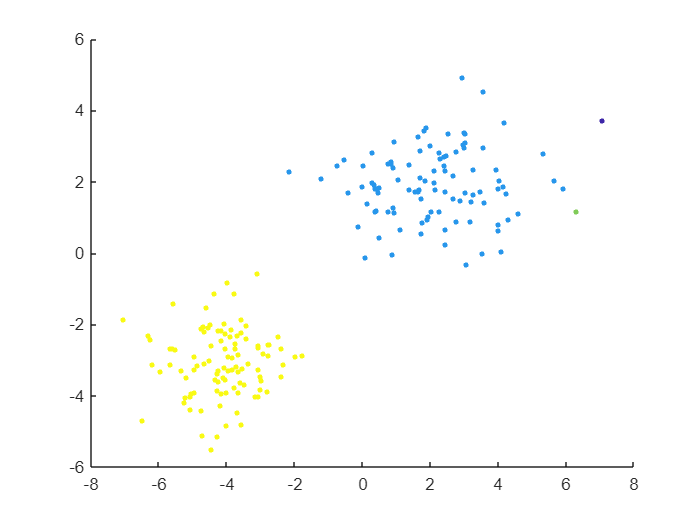

In [7]:
scatter(X(:,1),X(:,2),10,clx.labels_,"filled");

## More complex use cases and data conversion notes

Note that in the above clustering, CLASSIX found 4 clusters when we know the ground truth had 2. Two of those 'clusters' only had one data point in them though. We could use the <samp>minPts</samp> option to ensure that this does not happen. However, our first attempt results in an error message:


In [8]:
clx = py.classix.CLASSIX(radius=0.3, minPts=10, verbose=0);

Error using clustering>minPts
Python Error: TypeError: unsupported operand type(s) for &: 'float' and 'float'
Error in clustering>__init__ (line 398)


The reason for this is that in MATLAB a literal number such as <samp>10</samp> is of type double whereas in Python it is an integer. We need to be more explicit and make use of <samp>int32():</samp>



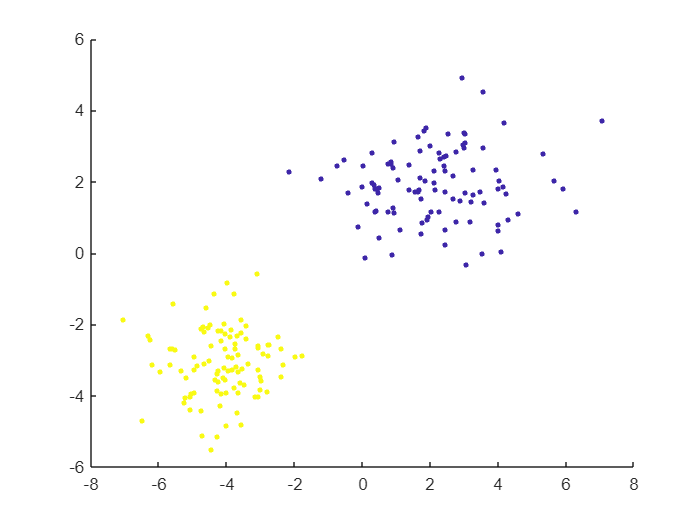

In [9]:
clx = py.classix.CLASSIX(radius=0.3, minPts=int32(10), verbose=0);
clx.fit(X);
scatter(X(:,1),X(:,2),10,clx.labels_,"filled");


Now, it looks like we have 2 clusters. The CLASSIX <samp>explain()</samp> method confirms this:


In [10]:
clx.explain()

A clustering of 200 data points with 2 features has been performed. 
The radius parameter was set to 0.30 and MinPts was set to 10. 
As the provided data has been scaled by a factor of 1/4.03,
data points within a radius of R=0.30*4.03=1.21 were aggregated into groups. 
In total 401 comparisons were required (2.00 comparisons per data point). 
This resulted in 28 groups, each uniquely associated with a starting point. 
These 28 groups were subsequently merged into 2 clusters. 
A list of all starting points is shown below.
----------------------------------------
 Group  NrPts  Cluster Coordinates 
   0      1      0       1.99 1.06 
   1      3      0       1.56 0.83 
   2      1      0        1.8 0.43 
   3      3      0       1.12 1.26 
   4     14      0       1.12 0.88 
   5     11      0        1.27 0.6 
   6     10      0       0.71 1.02 
   7      4      0        1.23 0.3 
   8     15      0       0.85 0.71 
   9      8      0       0.93 0.36 
  10      1      0        1.0 0.06 

## CLASSIX explainability and plotting from Python

A key feature of CLASSIX is that it can provide textual explanations of the computed clustering results, making it a fully explainable clustering algorithm. The CLASSIX <samp>explain()</samp> method can also produce plots, but you may receive an error message when attempting to do this from MATLAB:


In [11]:
clx.explain(plot=true)

Error using __init__
Python Error: TclError: Can't find a usable init.tcl in the following directories: 
    {C:/Program Files/Python311/lib/tcl8.6} {C:/Program Files/MATLAB/R2023b/bin/lib/tcl8.6} {C:/Program Files/MATLAB/R2023b/lib/tcl8.6} {C:/Program Files/MATLAB/R2023b/bin/library} {C:/Program Files/MATLAB/R2023b/library} {C:/Program Files/MATLAB/R2023b/tcl8.6.12/library} {C:/Program Files/MATLAB/tcl8.6.12/library}
This probably means that Tcl wasn't installed properly.
Error in _backend_tk>create_with_canvas (line 486)
Error in backend_bases>new_manager (line 1785)
Error in backend_bases>new_figure_manager_given_figure (line 3401)
Error in backend_bases>new_figure_manager (line 3396)
Error in pyplot>new_figure_manager (line 465)
Error in pyplot>figure (line 934)
Error in clustering>explain_viz (line 1459)
Error in clustering>explain (line 968)


This is explained on MATLAB Answers at [Why am I not able to call python Tkinter in MATLAB? - MATLAB Answers - MATLAB Central (mathworks.com)](https://uk.mathworks.com/matlabcentral/answers/808595-why-am-i-not-able-to-call-python-tkinter-in-matlab?s_tid=srchtitle). We need to provide paths to TCL.


In [12]:
% You'll need to find the correct paths on your machine.
setenv('TCL_LIBRARY', 'C:\Program Files\Python311\tcl\tcl8.6')
setenv('TK_LIBRARY', 'C:\Program Files\Python311\tcl\tk8.6')
clx.explain(plot=true)

A clustering of 200 data points with 2 features has been performed. 
The radius parameter was set to 0.30 and MinPts was set to 10. 
As the provided data has been scaled by a factor of 1/4.03,
data points within a radius of R=0.30*4.03=1.21 were aggregated into groups. 
In total 401 comparisons were required (2.00 comparisons per data point). 
This resulted in 28 groups, each uniquely associated with a starting point. 
These 28 groups were subsequently merged into 2 clusters. 
A list of all starting points is shown below.
----------------------------------------
 Group  NrPts  Cluster Coordinates 
   0      1      0       1.99 1.06 
   1      3      0       1.56 0.83 
   2      1      0        1.8 0.43 
   3      3      0       1.12 1.26 
   4     14      0       1.12 0.88 
   5     11      0        1.27 0.6 
   6     10      0       0.71 1.02 
   7      4      0        1.23 0.3 
   8     15      0       0.85 0.71 
   9      8      0       0.93 0.36 
  10      1      0        1.0 0.06 


The plot opens in a separate window and is not available inline in the live script. Here is the plot saved from the time I ran it on my machine:


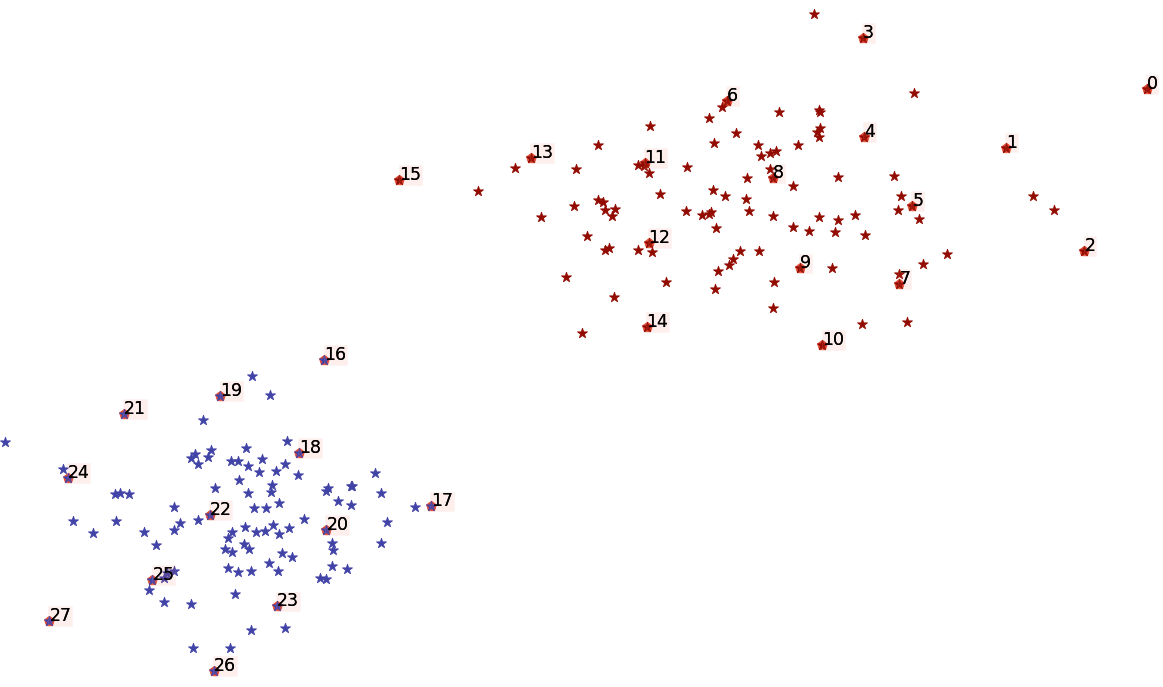


Note how CLASSIX has identified 28 special data points labelled with numbers <samp>0,1,...,27</samp> in the above data plot. These special data points, called **starting points,** are all farther than <samp>radius</samp> apart from each other in the Euclidean norm (after some scaling of the data to make the results scaling invariant). Data points in the neighborhood of a starting point form what is called a  **group.** Each **cluster** is made up of one or more groups.


CLASSIX uses the groups to explain why data points ended up in the same cluster, or why they are in separate clusters. For example, we can ask CLASSIX why data point 1 and 90 ended up in the same cluster #1 as shown below.


I**mportant note:** You might have to manually close the separate graphics window from the previous section to proceed.


In [13]:
clx.explain(int32(1), int32(90), plot=true)

----------------------------------------
 Group  NrPts  Cluster Coordinates  Label
   5     11      0       1.27 0.6     1  
  11     13      0      0.45 0.77    90  
----------------------------------------
The data point 1 is in group 5 and the data point 90 is in group 11, 
both of which were merged into cluster #0. 
These two groups are connected via groups 5 <-> 8 <-> 11.
connected_paths: [5, 8, 11]


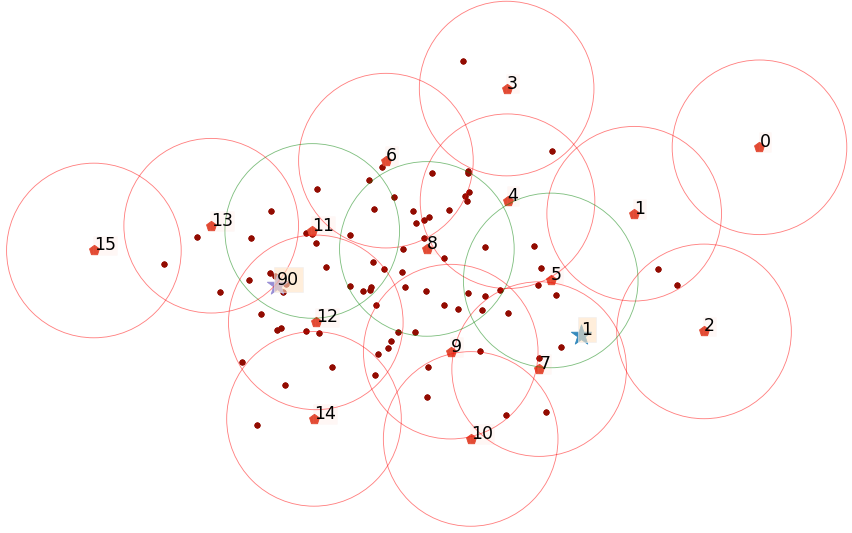


CLASSIX explains that data point 1 is in group 5, and data point 90 is in group 11, and there is a path via group 8 between these groups. In other words, we can go from data point 1 to 90 with two steps of length at most \texttt{1.5*radius} without leaving cluster 1. This is also shown visually in the above plot, with the groups 5, 8, and 11 highlighted by the green circles (the other groups are shown as red circles).

## Interactive use with Live Controls

Now we have everything working, we can explore the clustering options using interactive live controls. You'll only see these in the live script version, not the Jupyter notebook version.



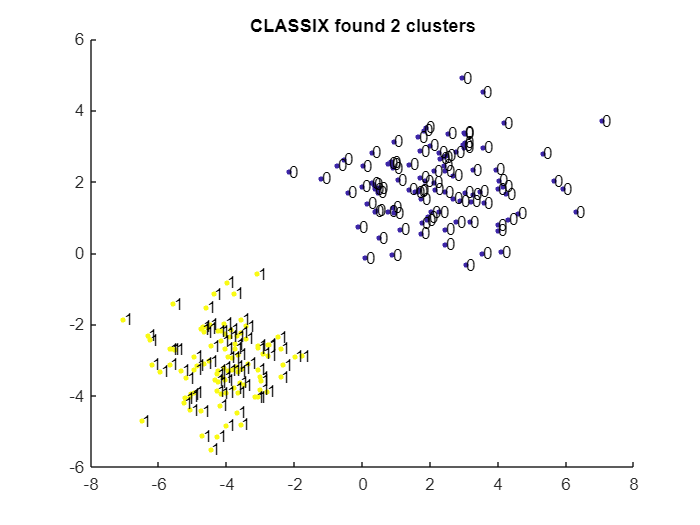

In [14]:
radius = 0.41;
minPts = 6;
showClusterNumbers = true;

clx = py.classix.CLASSIX(radius=radius, verbose=0, minPts=int32(minPts));
clx = clx.fit(X);
scatter(X(:,1),X(:,2),10,clx.labels_,"filled");
hold on
if showClusterNumbers
    labels = double(clx.labels_);
    for i=1:size(X,1)
        text(X(i,1),X(i,2),num2str(labels(i)));
    end
end
title(sprintf("CLASSIX found %d clusters",max(clx.labels_)+1))
hold off

## What is CLASSIX?

CLASSIX is a fast and memory-efficient clustering algorithm which produces explainable results. It exploits an initial sorting of the data points along their first principal axis to quickly assign data points to groups, followed by the merging of groups into clusters. In contrast to clustering methods like DBSCAN, CLASSIX does use any tree-based data structures to perform nearest-neighbor searches. In fact, CLASSIX's memory requirement grows only linearly in the number of data points. In contrast to the popular k-means algorithm, which is tailored to spherical clusters, CLASSIX can detect clusters of arbitrary shape.


If you'd like to learn more about CLASSIX, here are a couple of online references:

-  arXiv paper: [Fast and explainable clustering based on sorting (arxiv.org)](https://arxiv.org/abs/2202.01456)
-  GitHub page: [Fast and explainable clustering based on sorting (github.com)](https://github.com/nla-group/classix)
-  YouTube video: [CLASSIX - Fast and explainable clustering based on sorting - YouTube](https://www.youtube.com/watch?v=K94zgRjFEYo)
